# Pull All Late Night TV Show Youtube Stats

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from googleapiclient.discovery import build
import os

sys.path.append("../007-youtube-data-pull/")
from yt_pullers import pull_all_video_info

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [2]:
with open("/home/robmulla/Repos/data-science-youtube-stats/apikey/youtube.key") as f:
    youTubeApiKey = f.read()
# youTubeApiKey = _ #Read here
youtube = build("youtube", "v3", developerKey=youTubeApiKey)

In [5]:
# dfs = []
channels = [
    'Stephen Colbert',
    # 'Seth Meyers',
    # 'Daily Show',
    # 'Jimmy Kimmel',
    # 'Jimmy Fallon'
]

for channel in channels:
    print(channel)
    df = pull_all_video_info(channel, youtube, return_df=True)
    channelTitle = df["channelTitle"].values[0]
    df.to_csv(f"{channelTitle}.csv", index=False)
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True).copy()


df["publish_hour"] = df["publishTime"].dt.hour
df["publish_minute"] = df["publishTime"].dt.minute
df["publish_clock"] = df["publish_hour"] + df["publish_minute"] / 60
df["viewCountM"] = df["viewCount"] / 1_000_000  # Million Views
df.to_csv("late_night_youtube.csv", index=False)

In [44]:
df["publishTime"] = pd.to_datetime(df["publishTime"])
df["publishTimeEastern"] = df["publishTime"].dt.tz_convert("US/Eastern")
df["publish_hour_eastern"] = df["publishTimeEastern"].dt.hour
df["publish_minute_eastern"] = df["publishTimeEastern"].dt.minute
df["publish_clock_eastern"] = (
    df["publish_hour_eastern"] + df["publish_minute_eastern"] / 60
)

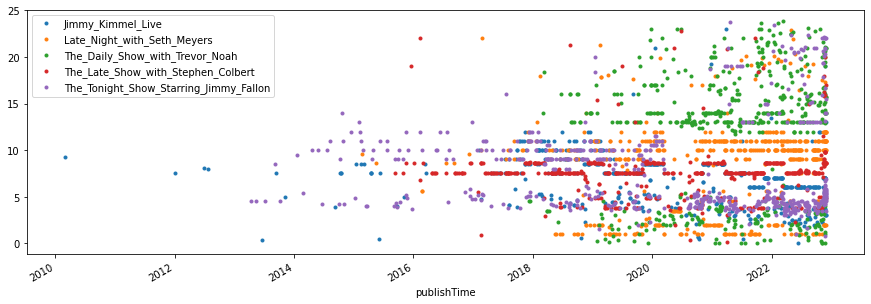

In [46]:
df.query('kind_stats == "youtube#video"').set_index("publishTime").groupby(
    "channelTitle"
)["publish_clock"].plot(figsize=(15, 5), style=".")
plt.legend()

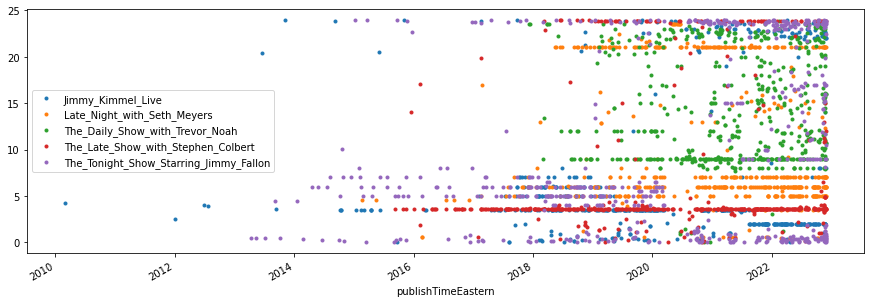

In [47]:
df.query('kind_stats == "youtube#video"').set_index("publishTimeEastern").groupby(
    "channelTitle"
)["publish_clock_eastern"].plot(figsize=(15, 5), style=".")
plt.legend()

In [51]:
df["publishYear"] = df["publishTimeEastern"].dt.year

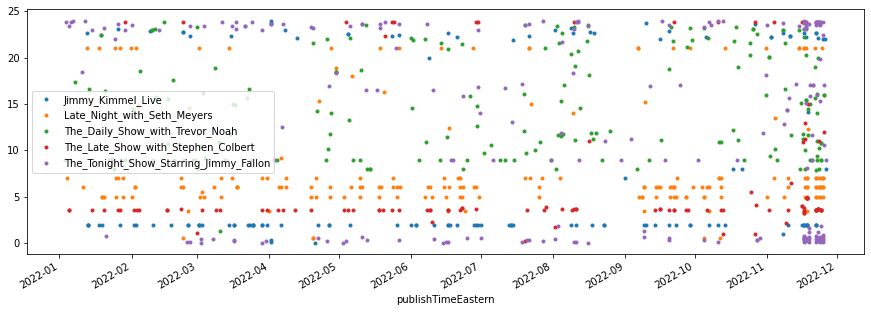

In [52]:
df.query('kind_stats == "youtube#video"').query("publishYear == 2022").set_index(
    "publishTimeEastern"
).groupby("channelTitle")["publish_clock_eastern"].plot(figsize=(15, 5), style=".")
plt.legend()

In [65]:
df["publishDateEastern"] = df["publishTimeEastern"].dt.date
df["publishMonthEastern"] = df["publishTimeEastern"].dt.month

In [70]:
df["channelTitle"].value_counts()

The_Tonight_Show_Starring_Jimmy_Fallon    560
The_Late_Show_with_Stephen_Colbert        535
Late_Night_with_Seth_Meyers               531
The_Daily_Show_with_Trevor_Noah           523
Jimmy_Kimmel_Live                         519
Name: channelTitle, dtype: int64

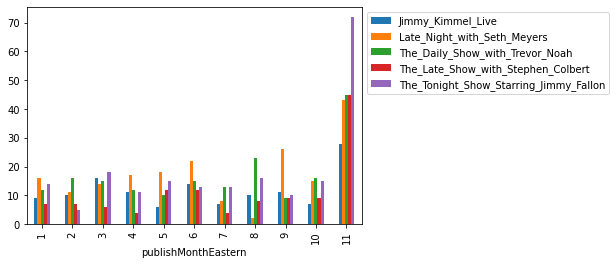

In [69]:
df.query("publishYear == 2022").groupby(
    [
        "publishMonthEastern",
        "channelTitle",
    ]
).size().unstack().fillna(0).plot(kind="bar")
plt.legend(bbox_to_anchor=(1, 1))

<AxesSubplot:xlabel='publishTime'>

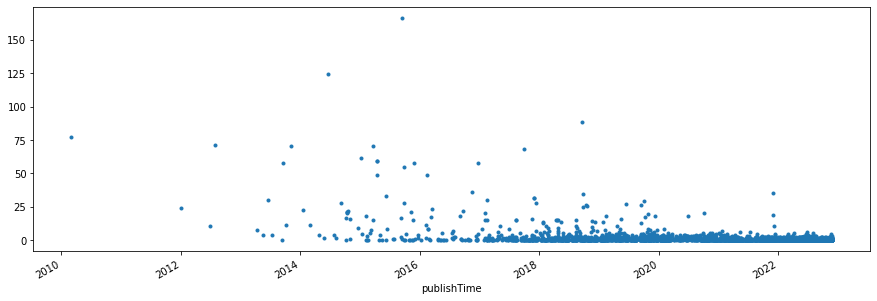

In [67]:
df.query('kind_stats == "youtube#video"').set_index("publishTime")["viewCountM"].plot(
    figsize=(15, 5), style="."
)

<AxesSubplot:xlabel='publishTime'>

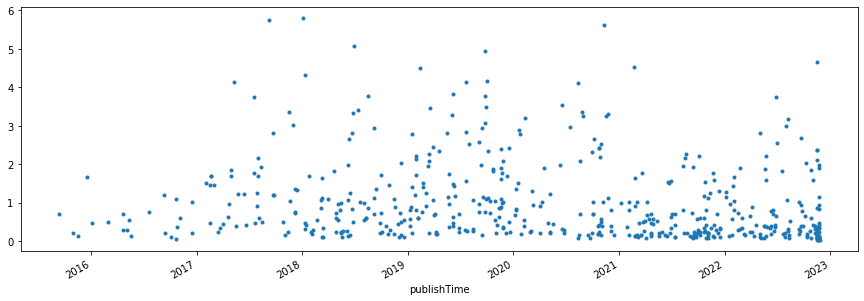

In [30]:
df.query("viewCountM < 10").set_index("publishTime")["viewCountM"].plot(
    figsize=(15, 5), style="."
)

In [31]:
df["publishYear"] = df["publishTime"].dt.year

In [32]:
df.columns

Index(['id', 'title', 'description', 'publishTime', 'kind_stats',
       'duration_seconds', 'viewCount', 'likeCount', 'commentCount',
       'thumbnails.default.url', 'thumbnails.default.width',
       'thumbnails.default.height', 'thumbnails.medium.url',
       'thumbnails.medium.width', 'thumbnails.medium.height',
       'thumbnails.high.url', 'thumbnails.high.width',
       'thumbnails.high.height', 'contentDetails.duration',
       'contentDetails.dimension', 'topicDetails.topicCategories',
       'snippet.defaultLanguage', 'localizations.en.title',
       'localizations.en.description', 'snippet.tags', 'channelTitle',
       'channelId', 'publish_hour', 'publish_minute', 'publish_clock',
       'viewCountM', 'publishYear'],
      dtype='object')

In [33]:
df["view_MSeconds"] = df["viewCountM"] * df["duration_seconds"]

In [34]:
df.groupby(["publishYear", "id"])["view_MSeconds"].sum().reset_index().groupby(
    "publishYear"
)["view_MSeconds"].agg(["mean", "sum", "count"])

,mean,sum,count
publishYear,,,
2015,405.529735,1622.118938,4
2016,1177.568099,23551.361975,20
2017,620.628333,25445.761648,41
2018,599.870505,44390.417406,74
2019,640.104907,65290.700491,102
2020,858.321078,54932.548967,64
2021,328.443406,32515.897191,99
2022,385.070762,46593.562216,121


# Pull All Results of Late Night Show